### Abstract. 

Classification of remote sensing multichannel images remains a challenging task due to the influence of several factors, including image compression and noise. In this study, we replicate and expand upon the previously conducted research on the classification of compressed noisy three-channel images by evaluating the potential of a new classifier based on the combination of Local Binary Patterns (LBP), color features, and the XGBoost algorithm. Specifically, we investigate the following factors: 1) the effect of residual noise after applying lossy compression to noisy images; 2) the impact of training a classifier on data that matches the quality conditions of the target compressed images; and 3) the benefits of post-filtering to improve the quality of compressed images before classification. Our experiments, conducted on Sentinel data with artificially added additive white Gaussian noise, demonstrate that the proposed LBP+Color+XGBoost classifier achieves competitive performance in handling noisy and compressed images. We confirm the importance of aligning classifier training with the quality conditions of the target images and highlight scenarios in which post-filtering can further enhance classification accuracy. These findings provide insights into the robustness of the LBP+Color+XGBoost pipeline for remote sensing data tasks involving challenging noise and compression conditions.

### Action Plan (in English)

1. **Develop a function to add Gaussian noise:**  
   Create a function that simulates the addition of Additive White Gaussian Noise (AWGN) to multichannel images.  

2. **Develop a function for image compression:**  
   Implement a function to compress images using lossy compression methods, such as JPEG or similar, with adjustable compression ratio parameters.

3. **Evaluate compressed images using PSNR:**  
   Develop a function to calculate the **Peak Signal-to-Noise Ratio (PSNR)** for compressed images. Use this function to identify the optimal compression ratio that yields the maximum PSNR value.

4. **Pixel-wise classification using the new classifier:**  
   Once the optimal compression point is determined, perform pixel-wise classification on the images using the proposed classifier **LBP+Color+XGBoost**. Analyze the classification results and assess the effectiveness of the new approach.

### Import libraries

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
def add_awgn_noise(image, sigma):
    """
    Adds Additive White Gaussian Noise (AWGN) to the image.

    :param image: Input RGB image as a NumPy array.
    :param sigma: Standard deviation of the noise (variance is sigma^2).
    :return: Image with added noise.
    """
    # Ensure the input is a valid NumPy array
    if not isinstance(image, np.ndarray):
        raise ValueError("Input image should be a NumPy array.")
    
    # Generate noise with a normal distribution
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    
    # Add noise to the image
    noisy_image = image.astype(np.float32) + noise
    
    # Clamp pixel values to the range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255)
    
    # Convert back to the original data type
    return noisy_image.astype(image.dtype)

In [22]:
def calculate_psnr(original, noisy):
    """
    Calculates PSNR (Peak Signal-to-Noise Ratio) between the original and noisy images.

    :param original: Original image as a NumPy array.
    :param noisy: Noisy image as a NumPy array.
    :return: PSNR value in decibels (float). Returns `inf` if the images are identical.
    """
    # Verify that the dimensions of the images match
    if original.shape != noisy.shape:
        raise ValueError("Original and noisy images must have the same shape.")

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original.astype(np.float32) - noisy.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')  # If MSE is zero, the images are identical.

    # Compute PSNR
    max_pixel = 255.0  # For 8-bit images
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

### Setting Up BGP Compression

There is no Python library that supports BGP directly, so we will use the command-line utilities `bpgenc` (for compression) and `bpgdec` (for decoding). We can integrate the calls to these utilities into Python using the `subprocess` library.

In progress ...

In [23]:
def display_multiple_images(images, titles, cmap=None):
    """
    Displays multiple images in a table layout in a Jupyter Notebook.

    :param images: List of images as NumPy arrays.
    :param titles: List of titles for the images.
    :param cmap: Color map; use 'gray' for monochrome images.
    """
    plt.figure(figsize=(15, 10))
    n = len(images)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(images[i].shape) == 2:  # Grayscale
            plt.imshow(images[i], cmap=cmap or 'gray')
        elif len(images[i].shape) == 3 and images[i].shape[2] == 3:  # RGB
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        else:
            raise ValueError("Unsupported image shape.")
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Results for image 1:
-------------------------------------------------------
Original: PSNR=N/A
Noise (σ=25): PSNR=21.40 dB
Noise (σ=50): PSNR=16.01 dB
Noise (σ=100): PSNR=10.85 dB
-------------------------------------------------------


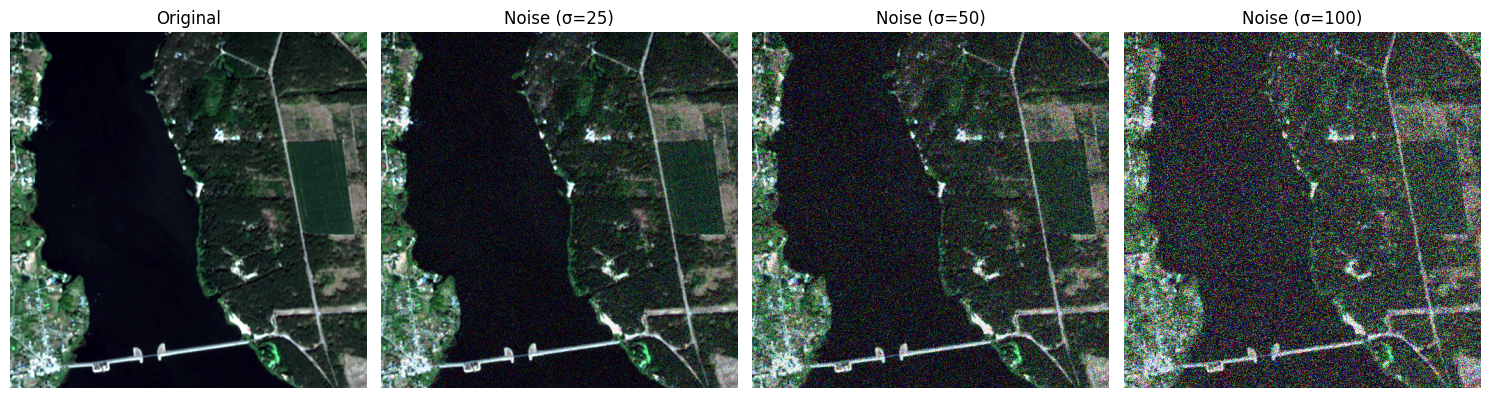

Results for image 2:
-------------------------------------------------------
Original: PSNR=N/A
Noise (σ=25): PSNR=20.69 dB
Noise (σ=50): PSNR=15.38 dB
Noise (σ=100): PSNR=10.61 dB
-------------------------------------------------------


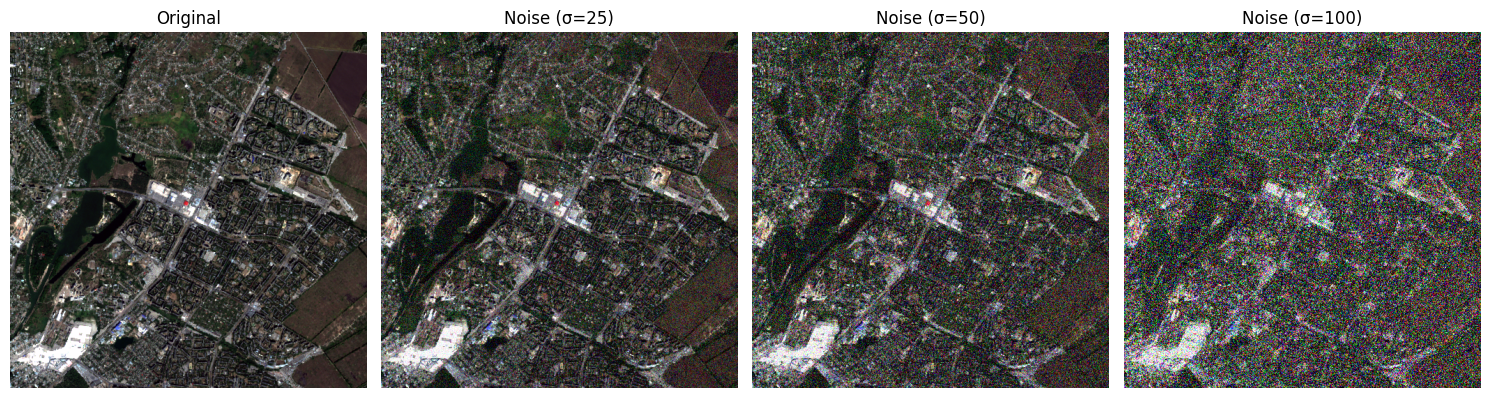

In [24]:
if __name__ == "__main__":
    # Load two RGB images from the specified paths
    image1 = cv2.imread("Images/sentinel/SS1/SS1.bmp", cv2.IMREAD_COLOR)
    image2 = cv2.imread("Images/sentinel/SS2/SS2.bmp", cv2.IMREAD_COLOR)
    
    # Check if the images were successfully loaded
    if image1 is None:
        raise FileNotFoundError("Image 'Images/sentinel/SS1/SS1.bmp' not found.")
    if image2 is None:
        raise FileNotFoundError("Image 'Images/sentinel/SS2/SS2.bmp' not found.")

    # Store images in a list for processing
    images = [image1, image2]
    sigmas = [25, 50, 100]  # Sigma values for adding noise

    # Process each image
    for idx, image in enumerate(images):
        results = [image]  # Start with the original image
        titles = ["Original"]  # Titles for display
        psnrs = ["N/A"]  # PSNR for the original image
        
        print(f"Results for image {idx + 1}:")
        print("-------------------------------------------------------")
        
        # Add noise for each sigma value
        for sigma in sigmas:
            # Add noise to the image
            noisy_image = add_awgn_noise(image, sigma)
            
            # Calculate PSNR between the original and noisy image
            psnr = calculate_psnr(image, noisy_image)
            psnrs.append(f"{psnr:.2f} dB")  # Format the PSNR value
            
            # Add the noisy image to the results list
            results.append(noisy_image)
            titles.append(f"Noise (σ={sigma})")
        
        # Print PSNR values to the console
        for title, psnr in zip(titles, psnrs):
            print(f"{title}: PSNR={psnr}")
        print("-------------------------------------------------------")
        
        # Display all results for the current image
        display_multiple_images(results, titles)